(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis and produce all relevant output graphs. If you want to download this notebook and execute it locally on your machine, download this file as a `ipynb` Jupyter notebook file and run it in your local python environment using the download button at the top of this page.

In [205]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, measurements, utils, stress_backend, plotting
import os
import datetime

from skimage import io

from scipy import stats

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from dask.distributed import Client

import yaml
from tifffile import imread

In [131]:
viewer = napari.Viewer(ndisplay=3)

## Load the data

Replace the following code with the commented out part (and remove the rest) below to load your own data for analysis:

In [4]:
root  = r'D:\Johannes\Shared\napari_stress_paper\data'
filename = os.path.join(root, '3DTimelapse-vsx0.346um-vsz4um-pinhole299um0-vst3min-16zSteps-30timeSteps-memNG-cy5Drop.lsm')
image = imread(filename)[:20]

In [5]:
image.shape

(20, 16, 3, 1024, 1024)

In [132]:
viewer.add_image(image[:, :, 0], name='membrane', colormap='green', blending='additive', scale=[1, 4, 0.346, 0.346])
viewer.add_image(image[:, :, 1], name='droplet', colormap='bop purple', blending='additive', scale=[1, 4, 0.346, 0.346])
viewer.add_image(image[:, :, 2], name='other', colormap='cyan', blending='additive', scale=[1, 4, 0.346, 0.346])

<Image layer 'other' at 0x23a026dd940>

### Data dimensions
You need to set a few parameters pertaining to your data:

In [7]:
voxel_size_x = 0.346  # microns
voxel_size_y = 0.346  # microns
voxel_size_z = 3.998  # microns
target_voxel_size = 1  # microns
time_step = 3  # minutes

### Analysis parameters

In case you ran the reconstruction previously interactively from the napari viewer (as explained [here](toolboxes:droplet_reconstruction:interactive)) and exported the settings, you can import the settings here, too. To do so, simply uncomment the line below (remove the `#`) and provide the path to the saved settings file:

In [8]:
# reconstruction_parameters = utils.import_settings(file_name='path/of/reconstruction/settings.yaml')
# measurement_parameters = utils.import_settings(file_name='path/of/measurement/settings.yaml')

If you used a parameter file, you can skip the next step. Otherwise, use this cell to provide the necessary parameters for the reconstruction and the measurement. The parameters are explained here:
- [Reconstruction](toolboxes:droplet_reconstruction:interactive)
- [Measurement](toolboxes:stress_toolbox:stress_toolbox_interactive)

In [9]:
## Reconstruction settings
smoothing_sigma = 3
n_smoothing_iterations = 10
n_points_first_guess = 1024
n_tracing_iterations = 2
resampling_length = 1
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 30
trace_sampling_distance = 1
interpolation_method = 'linear' # can be 'linear' 'cubic' or 'nearest'
outlier_tolerance = 1.0
remove_outliers = True

## Measurement settings
max_degree = 20  # spherical harmonics degree
n_quadrature_points = 5810  # number of quadrature points to measure on (maximum is 5180)
gamma = 3.3  # interfacial tension of droplet

In [10]:
reconstruction_parameters = None
measurement_parameters = None

*Hint:* Not sure whether the code is running probably? To show a progress bar for the processing of each timeframe, set the `verbose` parameter to `True`.  Also, in order to speed up computation, set the `parallelize` parameter to `True`.

In [11]:
verbose = False
parallelize = True

# Analysis

In [12]:
n_frames = image.shape[0]
n_frames

20

In [13]:
io.imsave(os.path.join(root, "original_data_droplet.tif"), image[:, :, 1, 300:600, 500:750])

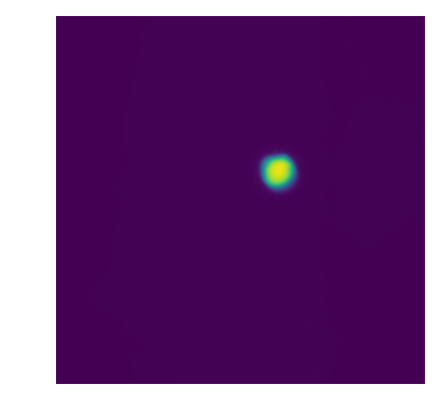

In [14]:
plt.imshow(image[:, :, 1].sum(axis=1).sum(axis=0))


In [15]:
image[:, :, 1, 300:600, 500:750].shape

(20, 16, 300, 250)

We put all parameters into a dictionary so we can save and reload them later:

In [16]:
if reconstruction_parameters is None:
    reconstruction_parameters = {
        'voxelsize': np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
        'target_voxelsize': target_voxel_size,
        'smoothing_sigma': smoothing_sigma,
        'n_smoothing_iterations': n_smoothing_iterations,
        'n_points': n_points_first_guess,
        'n_tracing_iterations': n_tracing_iterations,
        'resampling_length': resampling_length,
        'fit_type': fit_type,
        'edge_type': edge_type,
        'trace_length': trace_length,
        'sampling_distance': trace_sampling_distance,
        'interpolation_method':  interpolation_method,
        'outlier_tolerance': outlier_tolerance,
        'remove_outliers': remove_outliers}

if measurement_parameters is None:
    measurement_parameters = {
        'max_degree': max_degree,
        'n_quadrature_points': n_quadrature_points,
        'gamma': gamma}

We run the reconstruction and the stress analysis:

In [17]:
image[:, :, 1].shape

(20, 16, 1024, 1024)

In [19]:
results_reconstruction = reconstruction.reconstruct_droplet(image[:, :, 1], **reconstruction_parameters, use_dask=parallelize)

Dask client already running <Client: 'tcp://127.0.0.1:14792' processes=8 threads=40, memory=511.51 GiB>  Log: http://127.0.0.1:8787/status


In [20]:
_ = stress_backend.lbdv_info(Max_SPH_Deg=measurement_parameters['max_degree'],
                             Num_Quad_Pts=measurement_parameters['n_quadrature_points'])

results_stress_analysis = measurements.comprehensive_analysis(results_reconstruction[3][0], **measurement_parameters, use_dask=parallelize)

Dask client already running <Client: 'tcp://127.0.0.1:14792' processes=8 threads=40, memory=511.51 GiB>  Log: http://127.0.0.1:8787/status


In [133]:
for res in results_reconstruction + results_stress_analysis:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)

In [134]:
viewer.scale_bar.visible = True
viewer.scale_bar

ScaleBar(visible=True, colored=False, color=array([1., 0., 1., 1.], dtype=float32), ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, box=False, box_color=array([0. , 0. , 0. , 0.6], dtype=float32), unit=None)

## Create paper screenshots

In [209]:
figure_directory = r'D:\Johannes\Shared\napari_stress_paper\documents\figures\Figure6\imgs'

## Views on data

In [143]:
def set_timepoint(viewer, current_timepoint):
    # taken from https://github.com/haesleinhuepf/napari-time-slicer/blob/main/src/napari_time_slicer/_function.py
    variable_timepoint = list(viewer.dims.current_step)
    variable_timepoint[0] = current_timepoint
    viewer.dims.current_step = variable_timepoint

def make_layers_invisible(viewer):
    for layer in viewer.layers:
        layer.visible = False

In [177]:
timepoint = 10
set_timepoint(viewer, timepoint)

In [178]:
viewer.dims.ndisplay = 3
viewer.window.resize(1400, 800)
viewer.camera.center = (36, 148, 210)
viewer.camera.zoom = 20
viewer.camera.angles = (112, -30, -105)


viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].depicion = 'plane'

#### Total stress

In [179]:
make_layers_invisible(viewer)
viewer.layers['membrane'].visible = True
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False

viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

screenshot_total_stress = viewer.screenshot()
io.imsave(os.path.join(figure_directory, "droplet_membrane_total_stress.png"), screenshot_total_stress)

#### Cell stress

In [180]:
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_cell'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

screenshot_cell_stress = viewer.screenshot()
io.imsave(os.path.join(figure_directory, "droplet_membrane_cell_stress.png"), screenshot_cell_stress)

#### Tissue stress

In [181]:
viewer.layers['Result of lebedev quadrature (droplet)'].visible = False
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_color = 'stress_tissue'
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_contrast_limits = [-0.1, 0.1]
viewer.layers['Result of lebedev quadrature on ellipsoid'].refresh()
viewer.layers['Result of lebedev quadrature on ellipsoid'].size = 1

screenshot_tissue_stress = viewer.screenshot()
io.imsave(os.path.join(figure_directory, "droplet_membrane_tissue_stress.png"), screenshot_tissue_stress)

#### Extremal stresses

First select correct timepoint and plane

In [186]:
set_timepoint(viewer, 10)
viewer.dims.ndisplay = 2
viewer.dims.current_step=(10, 24, 512, 623)

viewer.window.resize(1400, 800)
viewer.camera.center = (0, 150, 213)
viewer.camera.zoom = 17


In [187]:
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature (droplet)'].size = 0.5
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh_colors(True)
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].visible = True
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].visible = True
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].width = 0.8

screenshot_nearest_extrema = viewer.screenshot()
io.imsave(os.path.join(figure_directory, "droplet_membrane_nearest_extrema.png"), screenshot_nearest_extrema)

### Extremal stress 3D

In [200]:
set_timepoint(viewer, 10)
viewer.dims.ndisplay = 3
viewer.camera.center = (40, 154, 210)
viewer.camera.zoom = 17
viewer.camera.angles = (112, -30, -105)
viewer.window.resize(1400, 800)
viewer.layers['membrane'].visible = True
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_cell'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()

screenshot_nearest_extrema_3d = viewer.screenshot()
io.imsave(os.path.join(figure_directory, "droplet_membrane_nearest_extrema_3d.png"), screenshot_nearest_extrema_3d)


In [201]:
set_timepoint(viewer, 10)
viewer.dims.ndisplay = 3
viewer.camera.center = (40, 154, 210)
viewer.camera.zoom = 17
viewer.camera.angles = (112, -30, -105)
viewer.window.resize(1400, 800)
viewer.layers['membrane'].visible = True
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total_extrema'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()

screenshot_nearest_extrema_3d = viewer.screenshot()
io.imsave(os.path.join(figure_directory, "droplet_membrane_nearest_extrema_3d_extrema_highlighted.png"), screenshot_nearest_extrema_3d)

To get an idea about the returned outputs and which is stored in which layer, let's print them:

In [202]:
for res in results_stress_analysis:
    print('-->', res[1]['name'])
    if 'metadata' in res[1].keys():
        for key in res[1]['metadata'].keys():
            print('\t Metadata: ', key)
    if 'features' in res[1].keys():
        for key in res[1]['features'].keys():
            print('\t Features: ', key)

--> Result of fit spherical harmonics (deg = 20)
	 Metadata:  Elipsoid_deviation_contribution_matrix
	 Metadata:  frame
	 Features:  fit_residue
	 Features:  frame
--> Result of expand points on ellipsoid
	 Features:  fit_residue
	 Features:  frame
--> Result of least squares ellipsoid
--> Result of lebedev quadrature on ellipsoid
	 Metadata:  Tissue_stress_tensor_cartesian
	 Metadata:  Tissue_stress_tensor_elliptical
	 Metadata:  Tissue_stress_tensor_elliptical_e1
	 Metadata:  Tissue_stress_tensor_elliptical_e2
	 Metadata:  Tissue_stress_tensor_elliptical_e3
	 Metadata:  stress_ellipsoid_anisotropy_e12
	 Metadata:  stress_ellipsoid_anisotropy_e23
	 Metadata:  stress_ellipsoid_anisotropy_e13
	 Metadata:  angle_ellipsoid_cartesian_e1_x1
	 Metadata:  angle_ellipsoid_cartesian_e1_x2
	 Metadata:  angle_ellipsoid_cartesian_e1_x3
	 Metadata:  stress_tissue_anisotropy
	 Metadata:  frame
	 Features:  mean_curvature
	 Features:  stress_tissue
	 Features:  frame
--> Result of lebedev quadrature 

To make handling further down easier, we store all metadata in a single dataframe if its length corresponds to the number of frames in the data:

In [203]:
# Compile data
df_over_time, df_nearest_pairs, df_all_pairs, df_autocorrelations = utils.compile_data_from_layers(
    results_stress_analysis, n_frames=n_frames, time_step=time_step)

In [222]:
%%capture
figures_dict = plotting.create_all_stress_plots(
    results_stress_analysis,
    time_step=time_step,
    n_frames=n_frames
)

## Quantitative plots

In [224]:
max_time = (image[:, :, 1].shape[0] - 1) * time_step

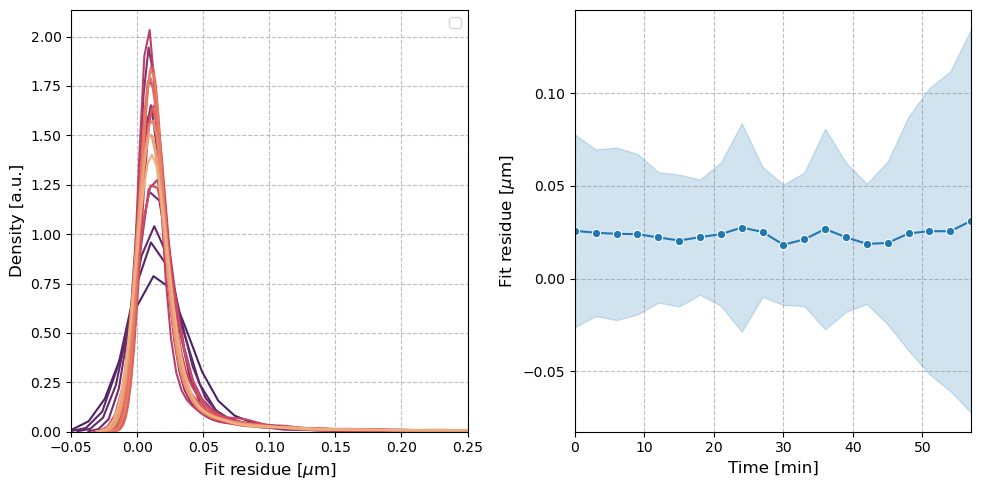

In [225]:
figure = figures_dict['Figure_reside']

figure['figure'].tight_layout()
figure['figure'].axes[0].set_xlim([-0.05, 0.25])
figure['figure'].axes[0].set_xlabel("Fit residue [$\mu$m]", fontsize=12)
figure['figure'].axes[0].set_ylabel("Density [a.u.]", fontsize=12)

figure['figure'].axes[1].set_xlabel("Time [min]", fontsize=12)
figure['figure'].axes[1].set_ylabel("Fit residue [$\mu$m]", fontsize=12)
figure['figure'].axes[1].set_xlim([0,  max_time])
figure['figure'].savefig(os.path.join(figure_directory, figure['path']), dpi=300)

figure['figure']

In [213]:
figure['figure'].axes

[<Axes: xlabel='fit_residue', ylabel='Density'>,
 <Axes: xlabel='time', ylabel='fit_residue'>]